<a href="https://colab.research.google.com/github/INFINITY-RUBER/Curso_de_Tensorflow-2.0_Guia_completa_para_el_Nuevo_Tensorflow/blob/master/Collab_12_Crear_una_API_para_Clasificar_Im%C3%A1genes_con_TensorFlow_Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Paso 1: Instalar las dependencias y configurar el proyecto en GPU


In [3]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   159k      0 --:--:-- --:--:-- --:--:--  159k
OK


In [2]:
!apt-get update & apt-get install tensorflow-model-server

Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Reading package lists... Done
Building depende

In [1]:
#!pip install tensorflow-gpu==1.13.1
!pip install tensorflow-gpu==1.15

In [71]:
!pip install requests

## Paso 2: Importar las dependencias del proyecto

In [5]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
# para qwue se quede la visualizacion en el notebook y no en una ventana aparte
%matplotlib inline 
tf.__version__

'1.15.0'

## Paso 3: Pre procesado de los datos

### Cargar el dataset

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [8]:
class_names = ['avión', 'coche', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión']

### Normalización de imágenes

In [9]:
X_train = X_train / 255.0 # normalizar la imagenes
X_test = X_test / 255.0

In [10]:
X_train.shape

(50000, 32, 32, 3)

## Paso 4: Definir el modelo

NOTA: Vamos a usar el mismo modelo que creamos en la Sección de Redes Neuronales Convolucionales

In [11]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Compilar el modelo

In [12]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])
# sparse_categorical_crossentropy>> Para cada uno de los vectores q tan probable es que la imagen se clasificada en ella

###  Entrenar el modelo

In [13]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=15)

Train on 50000 samples
Epoch 1/15
50000/50000 [==============================] - 8s 166us/sample - loss: 1.4932 - sparse_categorical_accuracy: 0.4612
Epoch 2/15
50000/50000 [==============================] - 5s 95us/sample - loss: 1.0420 - sparse_categorical_accuracy: 0.6317
Epoch 3/15
50000/50000 [==============================] - 5s 95us/sample - loss: 0.8622 - sparse_categorical_accuracy: 0.6992
Epoch 4/15
50000/50000 [==============================] - 5s 95us/sample - loss: 0.7484 - sparse_categorical_accuracy: 0.7404
Epoch 5/15
50000/50000 [==============================] - 5s 95us/sample - loss: 0.6666 - sparse_categorical_accuracy: 0.7671
Epoch 6/15
50000/50000 [==============================] - 5s 95us/sample - loss: 0.5925 - sparse_categorical_accuracy: 0.7945
Epoch 7/15
50000/50000 [==============================] - 5s 96us/sample - loss: 0.5276 - sparse_categorical_accuracy: 0.8154
Epoch 8/15
50000/50000 [==============================] - 5s 96us/sample - loss: 0.4582 - spar

### Evaluar el modelo

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 113us/sample - loss: 1.2320 - sparse_categorical_accuracy: 0.7386


In [15]:
print("La precisión del modelo es de {} %".format(test_accuracy*100.0))

La precisión del modelo es de 73.86000156402588 %


## Paso 5: Guardar el modelo para subir a producción

### Crear un directorio para el modelo

In [16]:
MODEL_DIR = "model/"
version = 1

In [56]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [57]:
if os.path.isdir(export_path):# si el directorio ya existe?
    !rm -r {export_path} # borrar el directorio

In [58]:
# EJEMPLO DE MODEL INPUT Y OUTPUT
model.input

<tf.Tensor 'conv2d_input:0' shape=(?, 32, 32, 3) dtype=float32>

In [59]:
# EJEMPLO DE MODEL INPUT Y OUTPUT
model.output

<tf.Tensor 'dense_1/Softmax:0' shape=(?, 10) dtype=float32>

### Guardar el modelo para TensorFlow Serving

In [60]:
tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})


INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model/1/saved_model.pb


## Paso 6: Configurar el entorno de producción

### Exportar el MODEL_DIR a las variables de entorno

In [61]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

In [75]:
os.environ

environ({'NO_GCE_CHECK': 'True', 'GCS_READ_CACHE_BLOCK_SIZE_MB': '16', 'CLOUDSDK_CONFIG': '/content/.config', '__EGL_VENDOR_LIBRARY_DIRS': '/usr/lib64-nvidia:/usr/share/glvnd/egl_vendor.d/', 'CUDA_VERSION': '10.1.243', 'PATH': '/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin', 'HOME': '/root', 'LD_LIBRARY_PATH': '/usr/lib64-nvidia', 'LANG': 'en_US.UTF-8', 'SHELL': '/bin/bash', 'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs', 'CUDA_PKG_VERSION': '10-1=10.1.243-1', 'SHLVL': '1', 'GCE_METADATA_TIMEOUT': '0', 'NCCL_VERSION': '2.4.8', 'NVIDIA_VISIBLE_DEVICES': 'all', 'TF_FORCE_GPU_ALLOW_GROWTH': 'true', 'DEBIAN_FRONTEND': 'noninteractive', 'CUDNN_VERSION': '7.6.5.32', 'LAST_FORCED_REBUILD': '20200729', 'JPY_PARENT_PID': '24', 'PYTHONPATH': '/env/python', 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\\"172.28.0.2

### Ejecutar la API REST de TensorFlow Serving

In [63]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8000 --model_name=cifar10 --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 4 in a separate thread.


In [65]:
!tail server.log

nohup: failed to run command 'tensorflow_model_server': No such file or directory


## Paso 7: Crear nuestra primera petición por POST

In [46]:
random_image = np.random.randint(0, len(X_test))
random_image

4831

### Crear el objeto de datos en JSON

In [66]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [74]:
data

'{"signature_name": "serving_default", "instances": [[[[0.996078431372549, 0.996078431372549, 0.996078431372549], [0.996078431372549, 0.996078431372549, 0.996078431372549], [0.996078431372549, 0.996078431372549, 0.996078431372549], [0.996078431372549, 0.996078431372549, 0.996078431372549], [0.996078431372549, 0.996078431372549, 0.996078431372549], [0.996078431372549, 0.996078431372549, 0.996078431372549], [0.996078431372549, 0.996078431372549, 0.996078431372549], [0.996078431372549, 0.996078431372549, 0.996078431372549], [0.996078431372549, 0.996078431372549, 0.996078431372549], [1.0, 0.996078431372549, 1.0], [1.0, 0.9921568627450981, 1.0], [0.9725490196078431, 0.9764705882352941, 0.9764705882352941], [0.9529411764705882, 0.9882352941176471, 0.9803921568627451], [0.7803921568627451, 0.8509803921568627, 0.8431372549019608], [0.5686274509803921, 0.6666666666666666, 0.6588235294117647], [0.4745098039215686, 0.596078431372549, 0.596078431372549], [0.4235294117647059, 0.5764705882352941, 0.

### Enviar la primera petición POST al modelo

In [73]:
headers = {"content-type":"application/json"}
headers

{'content-type': 'application/json'}

In [ ]:
json_response = requests.post(url="http://localhost:8010/v1/models/cifar10:predict", data=data, headers=headers)

In [ ]:
json_response

In [ ]:
predictions = json.loads(json_response.text)['predictions']

In [ ]:
predictions

[[1.26298616e-09,
  3.42567225e-11,
  2.43073339e-10,
  2.89047062e-08,
  4.87489042e-12,
  4.10505553e-11,
  3.08533615e-11,
  7.64918184e-07,
  1.75791507e-14,
  0.999999166]]

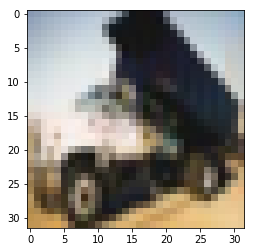

In [ ]:
plt.imshow(X_test[random_image])

In [ ]:
class_names[np.argmax(predictions[0])]

'camión'

## Paso 8: Enviar una petición POST a un modelo específico 

In [ ]:
specific_json_response = requests.post(url="http://localhost:8000/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [ ]:
specific_json_response

<Response [200]>